# The Transient Universe: part 2

In [1]:
import numpy as np
from scipy import stats, interpolate
import scipy.stats
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy import optimize
from scipy.optimize import curve_fit
import emcee
import dynesty

plt.rcParams['figure.figsize'] = [4, 4]

#### Data Catalogue
We have access to a catalouge containing some time-series measurements from a transient phenomenon. It's shaped in an (100x3) array. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux.

Text(0.5, 1.0, 'Transient phenomenas')

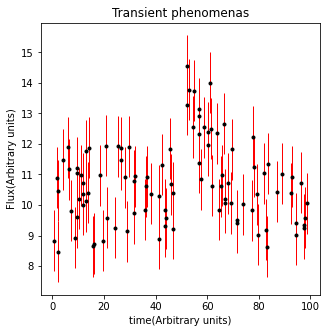

In [2]:
# Define the dimensionality of our problem.

x = np.load('../../solutions/transient.npy')
time = x[:,0]
flux = x[:,1]
d_flux = x[:,2]

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.errorbar(time, flux, d_flux, fmt='.k', lw=1, ecolor='red')
ax.set_xlabel('time(Arbitrary units)')
ax.set_ylabel('Flux(Arbitrary units)')
ax.set_title('Transient phenomenas')

#### defining values for our problem

In [3]:
ndim = 4 #b,A,to,alpha

t0min,t0max = 0,100
Amin,Amax=0,50
bmin,bmax=0,50
alphamin,alphamax=np.exp(-5),np.exp(5)

#### defining the two models we use to describe our data

In [4]:
def burst(t, par):
    b, A, to, alpha  = par
    return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))

def gaussian(t,par):
    b, A, to, sigma  = par
    return  b+A*np.exp(-(((t-to)/sigma)**2)/2)

## Nested sampling for burst model

In [5]:
def loglike_burst(par, time):
    y = burst(time, par)
    L = -0.5*np.sum((flux-y)**2 / d_flux**2)
    
    if not np.isfinite(L):
        L = -1e300
    
    return L
 
# Define our uniform prior.
def ptform_burst(u):
    
    x = np.array(u)  # copy u, u belongs to the hypercube [0,1]

    x[0] = scipy.stats.uniform(loc=Amin,scale=Amax-Amin).ppf(u[0])
    x[1] = scipy.stats.uniform(loc=bmin,scale=bmax-bmin).ppf(u[1])
    x[2] = scipy.stats.uniform(loc=t0min,scale=t0max-t0min).ppf(u[2])
    x[3] = scipy.stats.loguniform.ppf(u[3],alphamin,alphamax)

    return x

In [6]:
# "Static" nested sampling.
sampler = dynesty.NestedSampler(loglike_burst, ptform_burst, ndim, logl_args=[time], nlive=300) #nlive = 250 by default
sampler.run_nested()
sresults = sampler.results

C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_16272\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_16272\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
1115it [00:34,  9.18it/s, bound: 0 | nc: 74 | ncall: 11143 | eff(%): 10.006 | loglstar:   -inf < -170.591 <    inf | logz: -179.163 +/-  0.159 | dlogz: 93.257 >  0.309]    C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_16272\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
1125it [00:34, 15.07it/s, bound: 1 | nc: 2 | ncall: 11270 | eff(%):  9.982 | loglstar:   -inf < -164.257 <    inf | logz: -173.039 +/-  0.161 | dlogz: 87.140 >  0.309] C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_16272\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.ex

1771it [00:56, 16.92it/s, bound: 13 | nc: 8 | ncall: 16697 | eff(%): 10.607 | loglstar:   -inf < -89.192 <    inf | logz: -96.467 +/-  0.147 | dlogz: 28.981 >  0.309] C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_16272\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
1832it [00:58, 30.94it/s, bound: 14 | nc: 1 | ncall: 17098 | eff(%): 10.715 | loglstar:   -inf < -88.390 <    inf | logz: -95.694 +/-  0.146 | dlogz: 28.003 >  0.309] C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_16272\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_16272\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
1878it [00:59, 25.56it/s, bound: 14 | nc: 7 | ncall: 17524 | eff(%): 10.717 | loglstar:   -inf < -88.074 <    inf | logz: -95.239 +/-  0.145 | dlogz: 27.39

2262it [01:55,  1.19it/s, bound: 41 | nc: 275 | ncall: 29538 | eff(%):  7.658 | loglstar:   -inf < -87.103 <    inf | logz: -93.769 +/-  0.141 | dlogz: 33.098 >  0.309]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_16272\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
2263it [01:56,  1.24it/s, bound: 42 | nc: 160 | ncall: 29698 | eff(%):  7.620 | loglstar:   -inf < -87.102 <    inf | logz: -93.768 +/-  0.141 | dlogz: 33.093 >  0.309]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_16272\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
2265it [01:57,  1.40it/s, bound: 42 | nc: 31 | ncall: 30024 | eff(%):  7.544 | loglstar:   -inf < -87.102 <    inf | logz: -93.765 +/-  0.141 | dlogz: 33.083 >  0.309] C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_16272\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha

2383it [02:56,  3.40it/s, bound: 71 | nc: 114 | ncall: 43120 | eff(%):  5.526 | loglstar:   -inf < -86.978 <    inf | logz: -93.636 +/-  0.141 | dlogz: 34.622 >  0.309]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_16272\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_16272\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
2391it [02:58,  4.67it/s, bound: 72 | nc: 33 | ncall: 43629 | eff(%):  5.480 | loglstar:   -inf < -86.935 <    inf | logz: -93.628 +/-  0.141 | dlogz: 34.588 >  0.309] C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_16272\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_16272\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-a

2560it [03:51,  7.31it/s, bound: 100 | nc: 55 | ncall: 56208 | eff(%):  4.555 | loglstar:   -inf < -84.076 <    inf | logz: -93.269 +/-  0.145 | dlogz: 34.705 >  0.309] C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_16272\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_16272\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
2563it [03:53,  2.98it/s, bound: 101 | nc: 212 | ncall: 56570 | eff(%):  4.531 | loglstar:   -inf < -83.931 <    inf | logz: -93.248 +/-  0.145 | dlogz: 34.675 >  0.309]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_16272\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_16272\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(

2743it [04:15,  9.38it/s, bound: 115 | nc: 43 | ncall: 62912 | eff(%):  4.360 | loglstar:   -inf < -78.718 <    inf | logz: -90.095 +/-  0.181 | dlogz: 31.333 >  0.309]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_16272\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
2745it [04:16,  6.51it/s, bound: 116 | nc: 84 | ncall: 63049 | eff(%):  4.354 | loglstar:   -inf < -78.698 <    inf | logz: -90.034 +/-  0.181 | dlogz: 31.264 >  0.309]C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_16272\1884044262.py:3: RuntimeWarning: overflow encountered in multiply
  return  np.where(t<to,b,b+A*np.exp(-alpha*(t-to)))
2750it [04:17,  5.47it/s, bound: 116 | nc: 66 | ncall: 63409 | eff(%):  4.337 | loglstar:   -inf < -78.539 <    inf | logz: -89.887 +/-  0.181 | dlogz: 31.100 >  0.309] C:\Users\LEONARDO\AppData\Local\Temp\ipykernel_16272\1884044262.py:3: RuntimeWarning: overflow encountered in exp
  return  np.where(t<to,b,b+A*np.exp(-alph

#### Now we plot a summary of the run

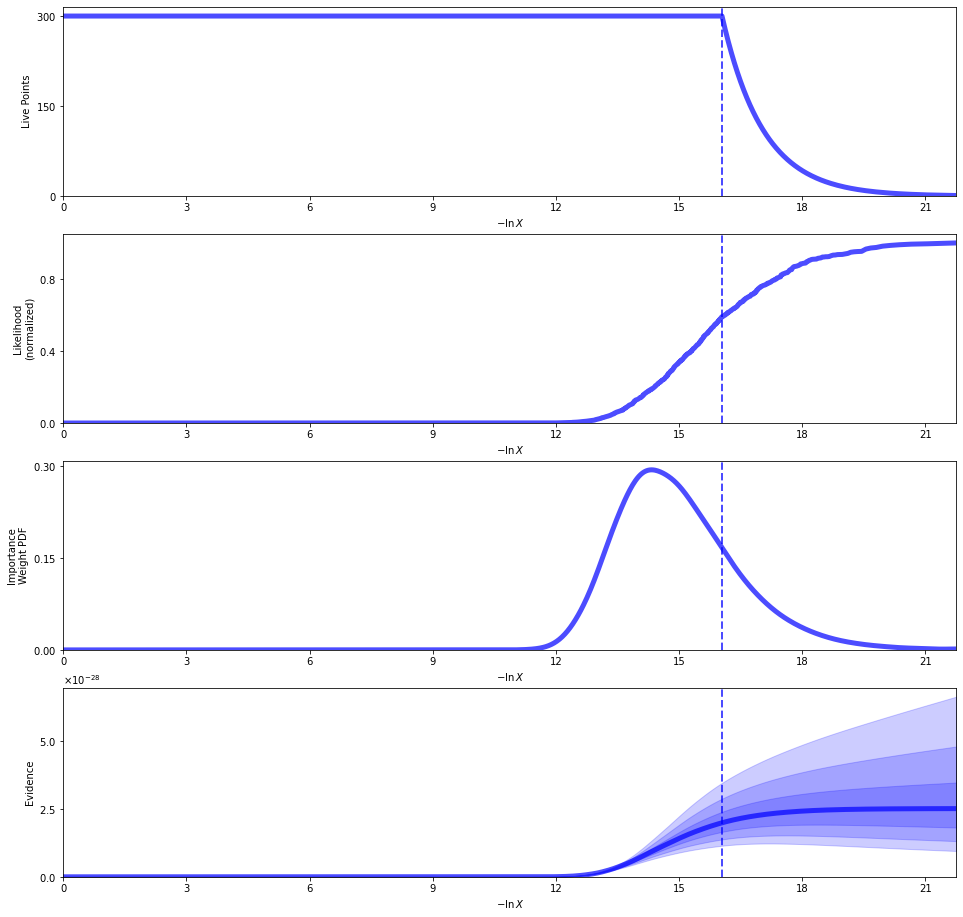

In [7]:
plt.rcParams['figure.figsize'] = [2, 2]
from dynesty import plotting as dyplot
rfig, raxes = dyplot.runplot(sresults)

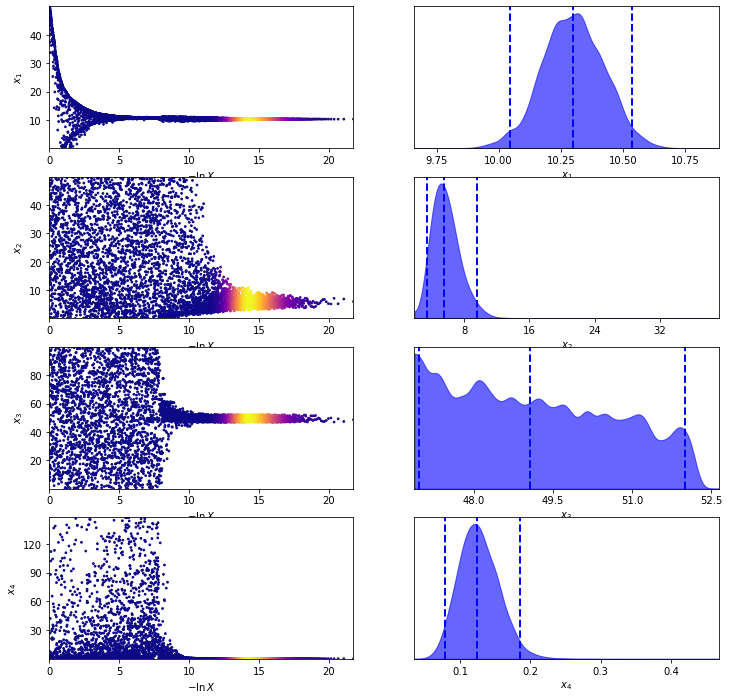

In [8]:
tfig, taxes = dyplot.traceplot(sresults)

Text(0.5, 1.04, 'Corner plot 4-D parameter space')

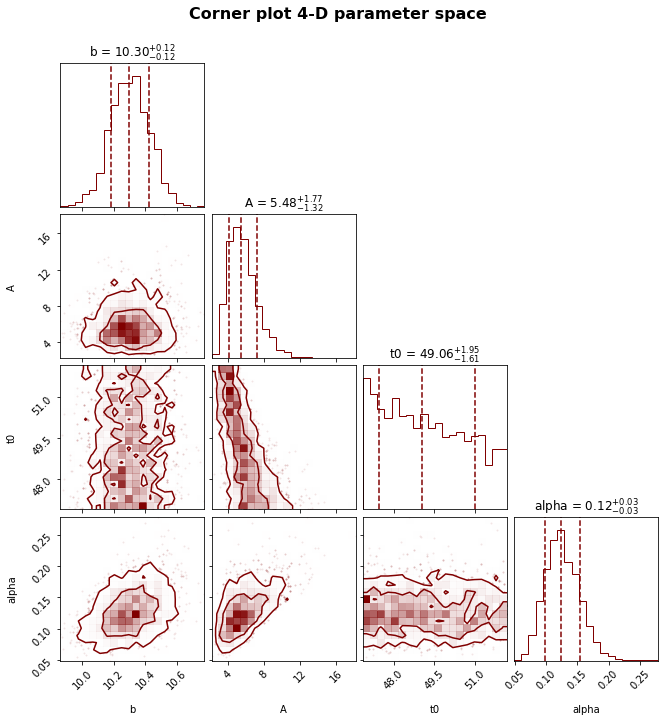

In [9]:
from dynesty import utils as dyfunc
import corner

samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights

labels = ["b","A","t0","alpha"]

samples_equal = dyfunc.resample_equal(samples, weights)

fig = corner.corner(samples_equal, labels=labels, levels=[0.68,0.95], quantiles =[0.16,0.5,0.84], show_titles= True, color = 'maroon');
fig.suptitle('Corner plot 4-D parameter space', fontsize = 16, fontweight="bold",  y=1.04)

In [10]:
evidence = sresults.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence))

# Compute 16%-84% quantiles.
quantiles = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights) for samps in samples.T]
print("16%-84% quantiles ")
for i,j in zip(np.arange(0,4,1), labels):
    print(j + ": " + str(quantiles[i]) + '\n')

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)
print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))


Bayesian evidence 2.504554070538903e-28
16%-84% quantiles 
b: [10.179085695317994, 10.421774581570867]

A: [4.157701247357382, 7.270062157510175]

t0: [47.4492267318109, 51.01873517214654]

alpha: [0.09900303256333058, 0.1537117120355813]

Mean and covariance of parameters are: [10.29940387  5.73727404 49.1961687   0.12650346]
[[ 1.50797981e-02  4.75602803e-03  3.97324697e-03  1.28394918e-03]
 [ 4.75602803e-03  2.73972802e+00 -1.70785368e+00  2.58112185e-02]
 [ 3.97324697e-03 -1.70785368e+00  2.30974388e+00 -6.77347005e-04]
 [ 1.28394918e-03  2.58112185e-02 -6.77347005e-04  7.82511559e-04]]


In [11]:
sresults.summary()

Summary
nlive: 300
niter: 4821
ncall: 81125
eff(%):  6.312
logz: -63.554 +/-  0.324


## Gaussian Model

In [12]:
sigmamin,sigmamax=np.exp(-2),np.exp(2)


def loglike_gaussian(par, time):
    y = gaussian(time, par)
    L = -0.5*np.sum((flux-y)**2 / d_flux**2)
    
    if not np.isfinite(L):
        L = -1e300
    
    return L
 
# Define our uniform prior.
def ptform_gaussian(u):
    
    x = np.array(u)  # copy u, u belongs to the hypercube [0,1]

    x[0] = scipy.stats.uniform(loc=Amin,scale=Amax-Amin).ppf(u[0])
    x[1] = scipy.stats.uniform(loc=bmin,scale=bmax-bmin).ppf(u[1])
    x[2] = scipy.stats.uniform(loc=t0min,scale=t0max-t0min).ppf(u[2])
    x[3] = scipy.stats.loguniform.ppf(u[3],sigmamin,sigmamax)

    return x

In [13]:
# "Static" nested sampling.
sampler_gaussian = dynesty.NestedSampler(loglike_gaussian, ptform_gaussian, ndim, logl_args=[time], nlive=300) #nlive = 250 by default
sampler_gaussian.run_nested()
sresults_gaussian = sampler_gaussian.results

2391it [03:07,  1.29it/s, bound: 99 | nc: 198 | ncall: 54761 | eff(%):  4.366 | loglstar:   -inf < -86.430 <    inf | logz: -94.208 +/-  0.148 | dlogz: 32.762 >  0.309]    C:\Users\LEONARDO\anaconda3\lib\site-packages\dynesty\bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
2754it [03:57,  4.68it/s, bound: 131 | nc: 46 | ncall: 69255 | eff(%):  3.977 | loglstar:   -inf < -76.934 <    inf | logz: -88.046 +/-  0.183 | dlogz: 25.412 >  0.309]  C:\Users\LEONARDO\anaconda3\lib\site-packages\dynesty\bounding.py:618: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are

#### Now we plot a summary of the run

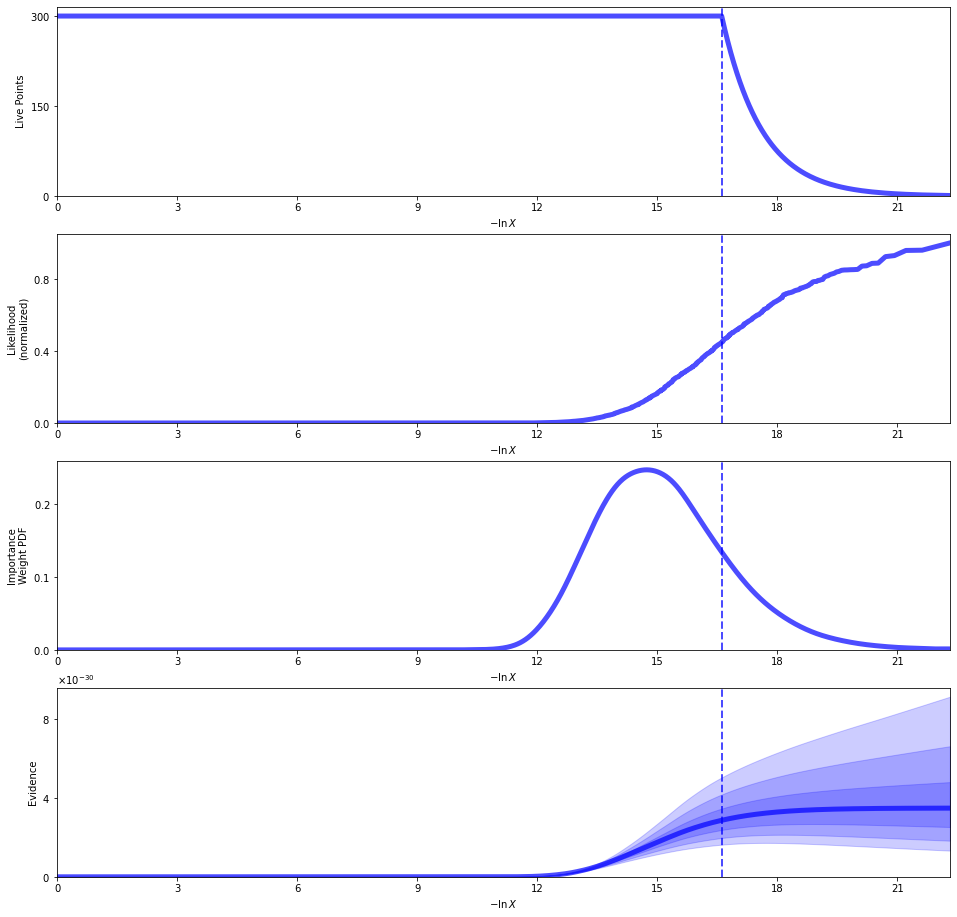

In [14]:
plt.rcParams['figure.figsize'] = [2, 2]
rfig, raxes = dyplot.runplot(sresults_gaussian)

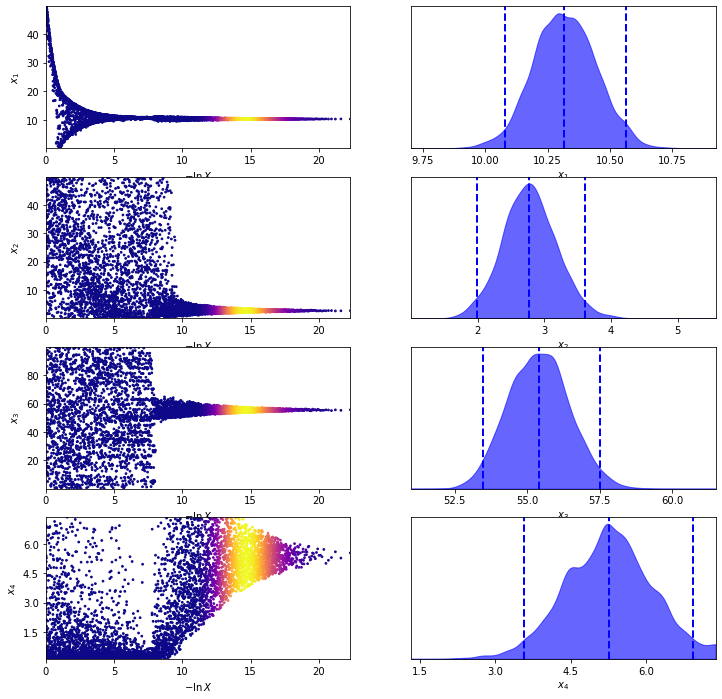

In [15]:
tfig, taxes = dyplot.traceplot(sresults_gaussian)

Text(0.5, 1.04, 'Corner plot 4-D parameter space')

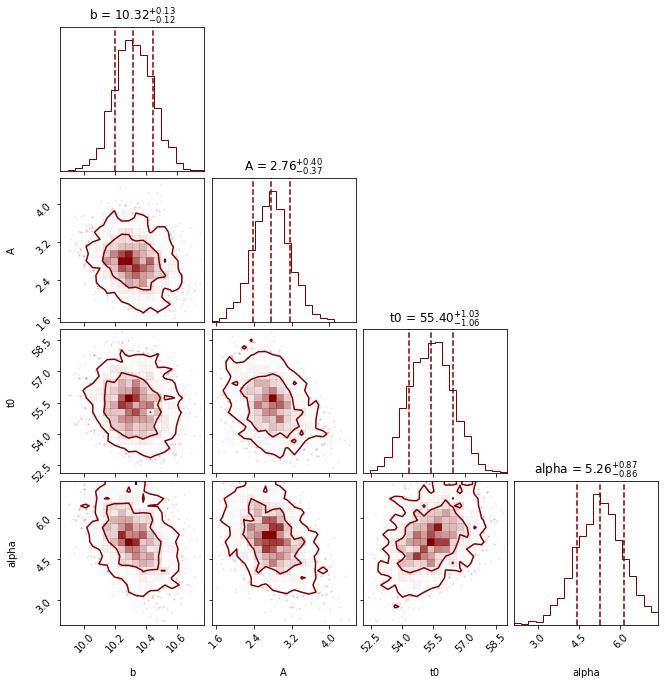

In [16]:
samples_gaussian = sresults_gaussian.samples  # samples
weights_gaussian = np.exp(sresults_gaussian.logwt - sresults_gaussian.logz[-1])  # normalized weights

labels = ["b","A","t0","alpha"]

samples_gaussian_equal = dyfunc.resample_equal(samples_gaussian, weights_gaussian)


ig = corner.corner(samples_gaussian_equal, labels=labels, levels=[0.68,0.95], quantiles =[0.16,0.5,0.84], show_titles= True, color = 'maroon');
fig.suptitle('Corner plot 4-D parameter space', fontsize = 16, fontweight="bold",  y=1.04)

In [17]:
evidence_gaussian = sresults_gaussian.logz[-1] #evidence
print("Bayesian evidence", np.exp(evidence_gaussian))

# Compute 16%-84% quantiles.
#quantiles = [dyfunc.quantile(samps, [0.16, 0.84], weights=weights_gaussian) for samps in samples.T]
#for i,j in zip(np.arange(0,4,1), labels):
#    print(j + ": " + str(quantiles[i]) + '\n')

# Compute weighted mean and covariance.
mean_gaussian, cov_gaussian = dyfunc.mean_and_cov(samples_gaussian, weights_gaussian)
print('Mean and covariance of parameters are: ' + str(mean_gaussian) + '\n' + str(cov_gaussian))


Bayesian evidence 3.476944981849304e-30
Mean and covariance of parameters are: [10.31841     2.77790771 55.39914052  5.24505264]
[[ 0.01551412 -0.01171412 -0.01912128 -0.04058549]
 [-0.01171412  0.16293018 -0.14638149 -0.13640483]
 [-0.01912128 -0.14638149  1.07711089  0.32068955]
 [-0.04058549 -0.13640483  0.32068955  0.73027053]]


## Model Comparison

To compare the two models, burst and gaussian, we relay on the computation of the Odds Ratio:

$$O_{21} = \frac{p(D\,|\,M_2,I)\,p(M_2\,|\,I)}{p(D\,|\,M_1,I)\,p(M_1\,|\,I)} $$

where $M_{1}$ is the burst model and $M_{2}$ is the gaussian model.

Supposing equal hyperpriors, we can just take the ratio between the two evidences $Z_{1}$ and $Z_{2}$.

In [18]:
O = np.exp(sresults.logz[-1])/np.exp(sresults_gaussian.logz[-1])
print("The Odds ratio is: %.3f" %O)

The Odds ratio is: 72.033


Using the Jeffrey's scale to convert the results in a qualitative phrase we can say there is a "very strong" evidence in favour of the burst model

## Robustness of the Odds Ratio 

let's variate the number of lives point to check if the odds ratio is robust with respect to the nested sampling hyperparameters

In [25]:
from tqdm import tqdm
import warnings


O21 = []
live_point=np.arange(250, 500, 50)

for i in range (5):
     with warnings.catch_warnings():
        warnings.simplefilter("ignore")
    
        "Burst"
        sampler_b = dynesty.NestedSampler(loglike_burst, ptform_burst, ndim, logl_args=[time], nlive=live_point[i]) 
        sampler_b.run_nested()
        sresults_b = sampler_b.results
        evidence_b = sresults.logz[-1]
    
        "Gaussian"
        sampler_g = dynesty.NestedSampler(loglike_gaussian, ptform_gaussian, ndim, logl_args=[time], nlive=live_point[i]) 
        sampler_g.run_nested()
        sresults_g = sampler_g.results
        evidence_g = sresults.logz[-1]
    
        "Odds Ratio"
        O21.append(np.exp(sresults_b.logz[-1])/np.exp(sresults_g.logz[-1]))
    
    
O21 = np.array(O21)
print(O21)

4030it [04:24, 15.26it/s, +250 | bound: 159 | nc: 1 | ncall: 68717 | eff(%):  6.251 | loglstar:   -inf < -48.769 <    inf | logz: -63.438 +/-  0.233 | dlogz:  0.001 >  0.259]
4164it [04:32, 15.27it/s, +250 | bound: 185 | nc: 1 | ncall: 78331 | eff(%):  5.653 | loglstar:   -inf < -52.434 <    inf | logz: -67.662 +/-  0.237 | dlogz:  0.001 >  0.259]
4843it [04:37, 17.44it/s, +300 | bound: 141 | nc: 1 | ncall: 74481 | eff(%):  6.933 | loglstar:   -inf < -48.756 <    inf | logz: -63.619 +/-  0.215 | dlogz:  0.001 >  0.309]
4986it [05:54, 14.07it/s, +300 | bound: 184 | nc: 1 | ncall: 93358 | eff(%):  5.680 | loglstar:   -inf < -52.485 <    inf | logz: -67.854 +/-  0.220 | dlogz:  0.001 >  0.309]
5556it [07:02, 13.15it/s, +350 | bound: 196 | nc: 1 | ncall: 115794 | eff(%):  5.116 | loglstar:   -inf < -48.765 <    inf | logz: -63.498 +/-  0.199 | dlogz:  0.001 >  0.359]
5758it [04:26, 21.64it/s, +350 | bound: 107 | nc: 1 | ncall: 68647 | eff(%):  8.943 | loglstar:   -inf < -52.472 <    inf | 

[ 68.27286701  69.1112884   76.18663327 124.62955754  70.77779988]


In [20]:
print(O21)

[167.08292465 138.11342346  57.82002237  95.40048009  69.36483137]


Text(0.5, 1.04, 'Posterior spread of the model vs data')

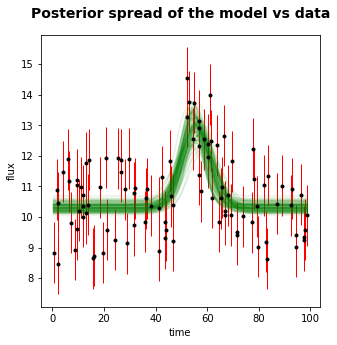

In [22]:
plt.rcParams['figure.figsize'] = [5, 5]
import random
random_samples = np.array(random.sample(samples_gaussian_equal.tolist(), k = 100))

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.errorbar(time, flux, d_flux, fmt='.k', lw=1, ecolor='red')

xgrid = np.linspace(min(time), max(time), len(time))

[plt.plot(xgrid, gaussian(xgrid, rs), color = 'green', alpha = 0.1) for rs in (random_samples)];
plt.xlabel('time')
plt.ylabel('flux')
plt.title('Posterior spread of the model vs data',fontsize = 14, fontweight="bold",  y=1.04)